## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def store_image(img, img_dir, fname):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    img_path = img_dir + fname.split('/')[-1]
    #print(img_path)
    cv2.imwrite(img_path, img)
        
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #store every images with detected corners for post analyse and writeup
            img_dir = 'output_images/chessboard_corners/'
            img_path = img_dir + fname.split('/')[-1]
            store_image(img, img_dir, img_path)
    #calibrate camera with identified objpoints and imgpoints
    img_size = (img.shape[1], img.shape[0])
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img_copy = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img_copy, cv2.COLOR_RGB2HLS).astype(np.float)
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    #l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #hsv[:,:,1]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def warp(img,tobird=True):
    corners = np.float32([[190,720],[590,460],[700,460],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0,0))    

# Calibrate camera

In [2]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

## Test pipeline on test images and store output

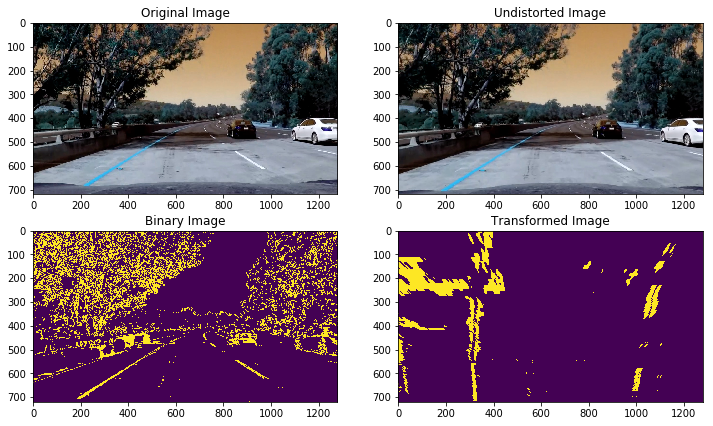

In [3]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

def preprocess_img(img):
    undist_img = undistort(img)
    binary_image = pipeline(undist_img)
    transformed = warp(binary_image)
    region_sel  = region_of_interest(transformed)
    return region_sel

# process test images
for fname in images:
    img = cv2.imread(fname)
    undist_img = undistort(img)
    #draw_lines(undist_img, src)
    store_image(undist_img, 'output_images/undistorted/', fname)
    binary_image = pipeline(undist_img)
    store_image(binary_image*255, 'output_images/binary_images/', fname)
    #transformed = transform(undist_img, src, dst)
    transformed = warp(binary_image)
    region_sel  = region_of_interest(transformed)
    store_image(region_sel*255, 'output_images/transformed_images/', fname)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undist_img)
plt.title("Undistorted Image")
#img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(binary_image*255)
plt.title("Binary Image")
plt.subplot(2, 2, 4)
plt.imshow(transformed*255)
plt.title("Transformed Image")

In [4]:
def slide_and_fitpoly(binary_warped, LL, RL, fname=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #plot
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lr, rr = calculate_curverad(left_fitx, right_fitx, ploty)
    lp = line_base_pos (left_fit, ploty)
    rp = line_base_pos (right_fit, ploty)
    
    #accept only radius over 100m
    if lr > 150 and lp < 2:
        LL.detected = True
        LL.recent_xfitted = left_fitx
        LL.current_fit = left_fit
        LL.radius_of_curvature = lr
        LL.allx = leftx
        LL.ally = lefty
        LL.line_base_pos = lp
    else:
        print('New detection not meeting expectations ' + 'lr: ' , lr, 'lp: ', lp)
    if rr > 150 and rp > 2 and rp < 2.5:
        RL.detected = True
        RL.recent_xfitted = right_fitx
        RL.current_fit = right_fit
        RL.radius_of_curvature = rr
        RL.allx = rightx
        RL.ally = righty
        RL.line_base_pos = rp
    else:
        print('New detection not meeting expectations ' + 'rr: ' , rr, 'rp: ', rp)
        
    if(fname!=None):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig(fname)
    
    #return left_fitx, right_fitx, ploty

#next frame fit poly
def fitpoly_next(binary_warped, LL, RL):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] - margin)) & (nonzerox < (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] - margin)) & (nonzerox < (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lr, rr = calculate_curverad(left_fitx, right_fitx, ploty)
    lp = line_base_pos (left_fit, ploty)
    rp = line_base_pos (right_fit, ploty)
    
    #accept only radius over 100m and left line position < 2 meters
    if lr > 150 and lp < 2:
        LL.detected = True
        LL.recent_xfitted = left_fitx
        LL.current_fit = left_fit
        LL.radius_of_curvature = lr
        LL.allx = leftx
        LL.ally = lefty
        LL.line_base_pos = lp
    else: 
        LL.detected = False
    #accept only radius over 100m and right line position > 2 meters
    if rr > 150 and rp > 2 and rp < 2.5:
        RL.detected = True
        RL.recent_xfitted = right_fitx
        RL.current_fit = right_fit
        RL.radius_of_curvature = rr
        RL.allx = rightx
        RL.ally = righty
        RL.line_base_pos = rp
    else:
        RL.detected = False
    

def calculate_curverad(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('left:', left_curverad, 'm', 'right:', right_curverad, 'm')
    return left_curverad, right_curverad

def line_base_pos(current_fit, ploty):
    y_eval = np.max(ploty)
    center_pos = 640
    line_pos = current_fit[0]*y_eval**2 + current_fit[1]*y_eval + current_fit[2]
    line_base_pos = (line_pos - center_pos)*3.7/600.0 #3.7 meters is about 600 pixels in the x direction
    
    # avoid negative distances, which would be the case for left lane
    # there is sure an more elegant way to handle this
    if line_base_pos < 0:
        line_base_pos *= (-1.0)
        
    return line_base_pos
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [5]:
# Generate x and y values for plotting
def draw_lane(undist, warped, LL, RL, fname=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([LL.recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([RL.recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, False) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #put radius info on image
    color = (0,255,0)
    position = (300,100)
    font = cv2.FONT_HERSHEY_SIMPLEX
    l = round(LL.radius_of_curvature, 2)
    r = round(RL.radius_of_curvature, 2)
    lp = round(LL.line_base_pos, 2)
    rp = round(RL.line_base_pos, 2)
    
    if l < 100 or r < 100:
        color = (255,0,0)
        position = (300,200)
        
    str1 = str('left rad: ' + str(l) + ' m' + ' ' + 'right rad: ' + str(r) + ' m')
    str2 = str('left dis: ' + str(lp) + ' m' + ' ' + 'right dis: ' + str(rp) + ' m')
    
    cv2.putText(result, str1, position, font, 1, color, 2, cv2.LINE_AA)
    cv2.putText(result, str2, (300, 300), font, 1, color, 2, cv2.LINE_AA)
    
    if fname!=None:
        plt.savefig(fname)
    
    return result

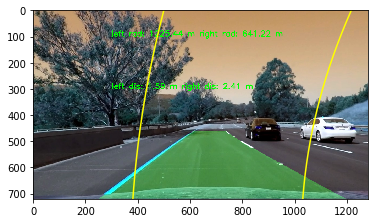

In [9]:
# process test images
#for fname in images:
global LL
global RL
img = cv2.imread('test_images/test6.jpg')
undist = undistort(img)
prep_img = preprocess_img(img)
slide_and_fitpoly(prep_img, LL, RL, 'output_images/left_fitx_right_fitx.jpg')
result = draw_lane(undist, prep_img, LL,  RL)
plt.imshow(result)
plt.savefig('output_images/test4_final_lane.jpg')       


In [7]:
def process_image(img):
    global LL
    global RL
    undist = undistort(img)
    prep_img = preprocess_img(img)
    if LL.detected == False or RL.detected == False:
        print('LL: ', LL.detected, 'RL: ', RL.detected, '-> start new detection cycle')
        slide_and_fitpoly(prep_img, LL, RL)
    else:
        fitpoly_next(prep_img, LL, RL)
    result = draw_lane(undist, prep_img, LL,  RL)
    return result

In [10]:
LL = Line()
RL = Line()

out_dir='./'
output = out_dir + 'processed_challenge_video.mp4'
clip = VideoFileClip('challenge_video.mp4')
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)

LL:  False RL:  False -> start new detection cycle
[MoviePy] >>>> Building video ./processed_challenge_video.mp4
[MoviePy] Writing video ./processed_challenge_video.mp4


  5%|▍         | 23/485 [00:03<01:12,  6.34it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  205.735661836 lp:  3.17996558554
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  218.660036223 lp:  3.22185136012


  5%|▌         | 25/485 [00:03<01:12,  6.38it/s]

LL:  False RL:  True -> start new detection cycle


  7%|▋         | 33/485 [00:05<01:10,  6.44it/s]

LL:  False RL:  True -> start new detection cycle


  8%|▊         | 39/485 [00:06<01:11,  6.25it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  395.556864059 lp:  3.30112671743
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  473.503917453 lp:  3.34131355181


  8%|▊         | 41/485 [00:06<01:10,  6.32it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  98.3142421855 lp:  1.23074498316
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  113.058029245 lp:  1.28701488697


  9%|▊         | 42/485 [00:06<01:10,  6.28it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  404.144361758 lp:  3.25093626691
New detection not meeting expectations rr:  1133.59272844 rp:  1.9945502335
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  106.152366685 lp:  1.43264977913
New detection not meeting expectations rr:  9297.89777526 rp:  1.86081067755


  9%|▉         | 45/485 [00:07<01:13,  6.02it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  112.772368875 lp:  1.50025087885
New detection not meeting expectations rr:  226.120211401 rp:  1.73823061381
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations rr:  181.218913874 rp:  1.89477873565


 11%|█         | 51/485 [00:08<01:11,  6.09it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  164.528973786 lp:  2.16538048581


 11%|█         | 54/485 [00:08<01:10,  6.15it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  292.365478976 lp:  2.65624433561
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  362.83281231 lp:  2.7569520294
New detection not meeting expectations rr:  186.927172741 rp:  1.71846617642


 11%|█▏        | 55/485 [00:08<01:11,  5.99it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  511.825280956 lp:  2.84127479558
New detection not meeting expectations rr:  131.747770488 rp:  2.45269061452
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  490.869466455 lp:  2.77980735072
New detection not meeting expectations rr:  188.274948812 rp:  1.72263858223


 12%|█▏        | 57/485 [00:09<01:11,  5.96it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  493.674868195 lp:  2.76576766039
New detection not meeting expectations rr:  175.13144828 rp:  1.70766054684
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  327.813175069 lp:  2.50595094109
New detection not meeting expectations rr:  168.590548918 rp:  1.69048168173


 12%|█▏        | 59/485 [00:09<01:11,  5.95it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations rr:  177.235052706 rp:  1.64657290923


 13%|█▎        | 64/485 [00:10<01:13,  5.71it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  116.037707978 rp:  2.17024944622


 13%|█▎        | 65/485 [00:10<01:23,  5.01it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  313.601642273 lp:  2.261115332
New detection not meeting expectations rr:  151.605801331 rp:  1.88850701094


 14%|█▎        | 66/485 [00:10<01:25,  4.90it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  142.188516823 rp:  1.88886859975
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  121.300396868 rp:  2.00844313676


 14%|█▍        | 68/485 [00:11<01:17,  5.37it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  138.93122823 rp:  1.88518380693
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  290.943409327 lp:  2.10910544141
New detection not meeting expectations rr:  200.0112493 rp:  1.65323206181


 14%|█▍        | 70/485 [00:11<01:14,  5.59it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  210.395112644 rp:  1.64633252825
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  341.760582006 lp:  2.11941342495
New detection not meeting expectations rr:  218.683131577 rp:  1.6320343379


 15%|█▍        | 72/485 [00:11<01:12,  5.70it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  419.235375104 lp:  2.17746078886
New detection not meeting expectations rr:  224.733030488 rp:  1.62715466159
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  473.995792819 lp:  2.21612988162
New detection not meeting expectations rr:  225.343066564 rp:  1.62465212349


 15%|█▌        | 75/485 [00:12<01:09,  5.86it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  496.066659468 lp:  2.20939338137
New detection not meeting expectations rr:  251.001527145 rp:  1.62786225
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  474.797063972 lp:  2.17293824895
New detection not meeting expectations rr:  3489.40134896 rp:  1.52705461526


 16%|█▌        | 76/485 [00:12<01:09,  5.91it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  472.495874135 lp:  2.16225831598
New detection not meeting expectations rr:  204.993252121 rp:  1.6696180175
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  472.63601157 lp:  2.15558944554
New detection not meeting expectations rr:  205.34404973 rp:  1.14611231193


 16%|█▌        | 78/485 [00:12<01:10,  5.81it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  492.114637105 lp:  2.13571296689
New detection not meeting expectations rr:  181.568930147 rp:  0.978615167281
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  458.793822137 lp:  2.11001926034
New detection not meeting expectations rr:  254.367588858 rp:  1.63645202868


 16%|█▋        | 80/485 [00:13<01:11,  5.68it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  526.244464689 lp:  2.14788584841
New detection not meeting expectations rr:  257.336391048 rp:  1.64548248753


 17%|█▋        | 81/485 [00:13<01:19,  5.08it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  468.191200599 lp:  2.10935579001
New detection not meeting expectations rr:  219.669750256 rp:  1.25917371395


 17%|█▋        | 82/485 [00:13<01:21,  4.95it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  586.936251578 lp:  2.15649817202
New detection not meeting expectations rr:  275.868726759 rp:  1.68101675797
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  446.068193803 lp:  2.03128318102
New detection not meeting expectations rr:  191.857992089 rp:  1.97550585621


 17%|█▋        | 84/485 [00:14<01:25,  4.70it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  509.787899223 lp:  2.07936514546
New detection not meeting expectations rr:  1318.84539646 rp:  1.94267271196
LL:  True RL:  False -> start new detection cycle


 18%|█▊        | 85/485 [00:14<01:20,  4.98it/s]

New detection not meeting expectations lr:  494.296393758 lp:  2.07943540081
New detection not meeting expectations rr:  482.217071353 rp:  1.80019821308
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  415.684552589 lp:  2.01916573089
New detection not meeting expectations rr:  776.255518998 rp:  1.72225008853


 18%|█▊        | 87/485 [00:14<01:14,  5.33it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  383.964512732 lp:  2.01320062799
New detection not meeting expectations rr:  262.261958464 rp:  1.82438899738


 18%|█▊        | 88/485 [00:14<01:23,  4.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  374.95897472 lp:  2.00947449052
New detection not meeting expectations rr:  260.847496405 rp:  1.74424119512


 18%|█▊        | 89/485 [00:15<01:25,  4.64it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  221.121885869 rp:  1.50425400196
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  276.82205753 rp:  1.49758535732


 19%|█▉        | 91/485 [00:15<01:21,  4.82it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  167.563236032 rp:  1.20759467787
LL:  True RL:  False -> start new detection cycle


 19%|█▉        | 92/485 [00:15<01:17,  5.04it/s]

New detection not meeting expectations rr:  171.455836513 rp:  1.07944812439
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  304.416516435 rp:  1.76682630426


 20%|█▉        | 95/485 [00:16<01:09,  5.64it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  346.29250801 rp:  1.73817919543
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  307.892661436 rp:  1.76238553651


 20%|█▉        | 96/485 [00:16<01:18,  4.93it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  411.956729578 rp:  1.73448455861
LL:  True RL:  False -> start new detection cycle


 20%|██        | 98/485 [00:16<01:12,  5.33it/s]

New detection not meeting expectations lr:  127.660314238 lp:  1.42573614005
New detection not meeting expectations rr:  253.412170725 rp:  1.77833476867
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  133.885263427 lp:  1.5546320342
New detection not meeting expectations rr:  270.502881148 rp:  1.74079097609


 20%|██        | 99/485 [00:17<01:11,  5.39it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  102.196783077 lp:  1.26895083387
New detection not meeting expectations rr:  343.307030713 rp:  1.7050647328
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  110.248345186 lp:  1.36690002227
New detection not meeting expectations rr:  284.336408561 rp:  1.72932467024


 21%|██        | 101/485 [00:17<01:09,  5.51it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  143.305528695 lp:  1.64349112902
New detection not meeting expectations rr:  303.652354485 rp:  1.74468726054


 21%|██        | 102/485 [00:17<01:17,  4.95it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  136.911085817 lp:  1.62146374479
New detection not meeting expectations rr:  327.349283419 rp:  1.7571053498


 21%|██▏       | 104/485 [00:17<01:11,  5.37it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  131.425004184 lp:  1.60239392608
New detection not meeting expectations rr:  304.807067604 rp:  1.79042146251
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  131.575352976 lp:  1.62089609417
New detection not meeting expectations rr:  346.5592603 rp:  1.78918459295


 22%|██▏       | 106/485 [00:18<01:06,  5.70it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  133.5810388 lp:  1.63392246909
New detection not meeting expectations rr:  272.81596555 rp:  1.8771512535
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  136.053569139 lp:  1.66784199621
New detection not meeting expectations rr:  263.373243837 rp:  1.88205163586


 22%|██▏       | 108/485 [00:18<01:04,  5.82it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1114.5549293 rp:  0.0317023735273
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  143.87960151 lp:  1.89075715746
New detection not meeting expectations rr:  266.966190631 rp:  1.84661754557


 23%|██▎       | 110/485 [00:19<01:03,  5.90it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  126.573318801 lp:  1.78130932345
New detection not meeting expectations rr:  298.725461166 rp:  1.80111975352
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  130.764566602 lp:  1.85798314163
New detection not meeting expectations rr:  245.29066914 rp:  1.83940552525


 23%|██▎       | 111/485 [00:19<01:04,  5.79it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  114.686989011 lp:  1.82877857295
New detection not meeting expectations rr:  223.158025909 rp:  1.84624900929
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  97.1469587292 lp:  1.83811994983
New detection not meeting expectations rr:  202.558800985 rp:  1.85995201348


 23%|██▎       | 113/485 [00:19<01:03,  5.85it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  67.4788184127 lp:  1.55357414409
New detection not meeting expectations rr:  398.756268468 rp:  1.65840002536
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  68.4201715422 lp:  1.53912681425
New detection not meeting expectations rr:  207.403000654 rp:  1.85398084824


 24%|██▎       | 115/485 [00:19<01:01,  5.97it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  105.098657819 lp:  1.87076909465
New detection not meeting expectations rr:  258.23862846 rp:  1.83157513346
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  96.0765326797 lp:  1.88668947118
New detection not meeting expectations rr:  257.684747185 rp:  1.8517105404


 24%|██▍       | 117/485 [00:20<01:09,  5.30it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  46.6264451834 lp:  1.37859919095
New detection not meeting expectations rr:  404.191490358 rp:  1.79240780234
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  42.905359483 lp:  1.43624796429
New detection not meeting expectations rr:  453.9251411 rp:  1.83843443277


 25%|██▍       | 120/485 [00:20<01:01,  5.89it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  56.2913128649 lp:  1.63166761608
New detection not meeting expectations rr:  906.814742533 rp:  1.93733107509
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  357.204081198 lp:  2.05006019753


 25%|██▌       | 123/485 [00:21<00:59,  6.04it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  112.535101221 lp:  1.90681699245
New detection not meeting expectations rr:  190.459786736 rp:  2.57757971452
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  55.3968973871 lp:  1.70547347439


 26%|██▌       | 125/485 [00:21<01:07,  5.37it/s]

LL:  False RL:  True -> start new detection cycle


 26%|██▋       | 128/485 [00:22<01:03,  5.61it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  718.39553813 rp:  1.84030809902
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  462.072171422 rp:  1.8212073072


 27%|██▋       | 129/485 [00:22<01:01,  5.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  494.916786376 rp:  1.81927665194
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  486.87155123 rp:  1.81511654765


 27%|██▋       | 131/485 [00:22<01:01,  5.72it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  459.064567025 rp:  1.8029785071
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  511.137641433 rp:  0.243712766722


 28%|██▊       | 134/485 [00:23<01:00,  5.80it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  380.001707866 rp:  0.359857723438
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  4.77506408346 lp:  2.12958791377
New detection not meeting expectations rr:  496.678578168 rp:  0.232312499111


 28%|██▊       | 136/485 [00:23<00:58,  5.95it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  4.57754512401 lp:  2.81536193204
New detection not meeting expectations rr:  339.82280471 rp:  0.43286754092
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  2.5727621854 lp:  2.44269158047
New detection not meeting expectations rr:  331.516277307 rp:  0.416612056954


 28%|██▊       | 137/485 [00:23<01:00,  5.80it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  3.42140173252 lp:  2.35154921805
New detection not meeting expectations rr:  379.458757359 rp:  0.343040191807
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  7.15517919954 lp:  2.43948370061
New detection not meeting expectations rr:  462.19954287 rp:  0.249088345588


 29%|██▊       | 139/485 [00:24<01:08,  5.06it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  13.1806641025 lp:  2.46495223809
New detection not meeting expectations rr:  481.199569519 rp:  0.229844742012


 29%|██▉       | 140/485 [00:24<01:07,  5.12it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  842.985373619 lp:  2.19829608446
New detection not meeting expectations rr:  315.044180842 rp:  1.8961396649
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  448.428376867 rp:  0.240047550309


 29%|██▉       | 142/485 [00:24<01:04,  5.30it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  411.395675782 rp:  0.241679458204
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  350.953474442 rp:  1.81608397729


 30%|██▉       | 144/485 [00:25<01:07,  5.02it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  383.937348034 rp:  1.79968352837


 30%|██▉       | 145/485 [00:25<01:11,  4.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  388.852498883 rp:  1.76189693386


 30%|███       | 146/485 [00:25<01:08,  4.94it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1096.789658 lp:  2.14451389978
New detection not meeting expectations rr:  489.167619165 rp:  1.75573241023
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1425.68352655 lp:  2.1904850609
New detection not meeting expectations rr:  481.211818695 rp:  0.222018170273


 31%|███       | 148/485 [00:25<01:03,  5.33it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1902.4334989 lp:  2.23024255136
New detection not meeting expectations rr:  489.267760455 rp:  0.214368881519
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1292.72703333 lp:  2.16466332606
New detection not meeting expectations rr:  492.87630113 rp:  0.19754954807


 31%|███       | 150/485 [00:26<00:59,  5.60it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1447.9369357 lp:  2.15400780227
New detection not meeting expectations rr:  526.312047747 rp:  0.180362286489
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1419.6571343 lp:  2.12121431937
New detection not meeting expectations rr:  475.713845177 rp:  0.188682300184


 31%|███▏      | 152/485 [00:26<00:59,  5.64it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1214.28880483 lp:  2.08254732301
New detection not meeting expectations rr:  539.464062009 rp:  0.149375227761
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  920.148337143 lp:  2.00936178642
New detection not meeting expectations rr:  320.79058194 rp:  1.85793541478


 32%|███▏      | 154/485 [00:26<00:57,  5.73it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  612.997954763 rp:  0.120291711737


 32%|███▏      | 155/485 [00:27<01:06,  4.99it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  644.302547278 rp:  0.118213949847


 32%|███▏      | 156/485 [00:27<01:08,  4.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  402.139666426 rp:  1.81525293238
LL:  True RL:  False -> start new detection cycle


 32%|███▏      | 157/485 [00:27<01:05,  5.00it/s]

New detection not meeting expectations rr:  454.504934246 rp:  1.80489232484
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  405.086704215 rp:  1.81450780827


 33%|███▎      | 159/485 [00:27<01:02,  5.23it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  714.73389184 rp:  0.10950079284
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  695.512584291 rp:  0.109631198357


 33%|███▎      | 161/485 [00:28<00:59,  5.49it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  754.995134395 rp:  0.1005825433
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  337.38876338 rp:  1.87486188917


 34%|███▎      | 163/485 [00:28<00:56,  5.74it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  317.700363233 rp:  1.86256076439
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  359.897730982 rp:  1.82441667516


 34%|███▍      | 165/485 [00:28<00:56,  5.71it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  360.60605077 rp:  1.80454563607
LL:  True RL:  False -> start new detection cycle


 34%|███▍      | 166/485 [00:29<00:57,  5.57it/s]

New detection not meeting expectations rr:  360.264235194 rp:  1.80514737092


 34%|███▍      | 167/485 [00:29<01:04,  4.90it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  381.913500402 rp:  1.78615701218


 35%|███▍      | 168/485 [00:29<01:08,  4.62it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1140.06936797 rp:  1.70249298339
LL:  True RL:  False -> start new detection cycle


 35%|███▍      | 169/485 [00:29<01:04,  4.92it/s]

New detection not meeting expectations rr:  441.600036281 rp:  1.74950922935
LL:  True RL:  False -> start new detection cycle


 35%|███▌      | 170/485 [00:30<01:06,  4.74it/s]

New detection not meeting expectations rr:  346.982344303 rp:  1.77864661801


 35%|███▌      | 171/485 [00:30<01:08,  4.58it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  391.154238138 rp:  1.76356463176


 35%|███▌      | 172/485 [00:30<01:07,  4.66it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  415.668151502 rp:  1.75778239741
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  363.049652266 rp:  1.79639344801


 36%|███▌      | 174/485 [00:30<01:04,  4.85it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  387.169032198 rp:  1.78864151658


 36%|███▌      | 175/485 [00:31<01:06,  4.66it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  447.570739877 rp:  1.74977068519
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  336.35660905 rp:  1.81354154505


 36%|███▋      | 177/485 [00:31<00:59,  5.17it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  348.842417948 rp:  1.81494452648
LL:  True RL:  False -> start new detection cycle


 37%|███▋      | 178/485 [00:31<01:02,  4.93it/s]

New detection not meeting expectations rr:  321.166883351 rp:  1.80586382476
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  359.792076227 rp:  1.77348147636


 37%|███▋      | 180/485 [00:32<00:57,  5.31it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  425.251918243 rp:  1.75098550352
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  446.810496833 rp:  1.76929791082


 38%|███▊      | 183/485 [00:32<00:53,  5.67it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  367.016591567 rp:  1.76111594583
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  354.159998803 rp:  1.78112110562


 38%|███▊      | 184/485 [00:32<00:52,  5.74it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  361.284330284 rp:  1.77060975106
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  416.414062578 rp:  1.77315154536


 38%|███▊      | 186/485 [00:33<00:52,  5.68it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  419.045418359 rp:  1.77451577918
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  386.6607719 rp:  1.80261966893


 39%|███▉      | 188/485 [00:33<00:51,  5.79it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  341.571082524 rp:  0.142606182686
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  359.826391304 rp:  0.128404071855


 39%|███▉      | 190/485 [00:33<00:51,  5.75it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  362.331007089 rp:  0.127640443296
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  366.670941492 rp:  0.128744342149


 40%|███▉      | 192/485 [00:34<00:52,  5.54it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  359.315518107 rp:  0.117603360388


 40%|███▉      | 193/485 [00:34<00:56,  5.20it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  306.842801462 rp:  1.82163252542
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  283.038535719 rp:  1.82262233057


 40%|████      | 196/485 [00:34<00:50,  5.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  275.986914194 rp:  1.81627251532
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  284.671164561 rp:  1.79707518098


 41%|████      | 198/485 [00:35<00:50,  5.73it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  285.086188935 rp:  1.793077124
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  313.927404105 rp:  1.7868669787


 41%|████      | 200/485 [00:35<00:48,  5.92it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  309.081753032 rp:  1.79096788966
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  295.622932243 rp:  1.81529362467


 41%|████▏     | 201/485 [00:35<00:49,  5.70it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  286.609260986 rp:  1.82828773436


 42%|████▏     | 202/485 [00:36<00:53,  5.33it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  303.73618213 rp:  1.81376615458


 42%|████▏     | 203/485 [00:36<00:56,  5.02it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  305.426657403 rp:  1.79383949753
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  321.97493506 rp:  1.77070136026


 42%|████▏     | 205/485 [00:36<00:51,  5.42it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  327.542463108 rp:  1.74236292481
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  291.54347339 rp:  1.76763854144


 43%|████▎     | 207/485 [00:36<00:53,  5.16it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  284.32794079 rp:  1.76787464862


 43%|████▎     | 208/485 [00:37<00:55,  5.03it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  292.407467368 rp:  1.76869287961
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  314.456274594 rp:  1.75899624238


 43%|████▎     | 210/485 [00:37<00:51,  5.39it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  332.547514585 rp:  1.74888794186
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  322.678442229 rp:  1.73823618269


 44%|████▎     | 212/485 [00:37<00:48,  5.64it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  299.523187603 rp:  1.72656610391
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  296.353852423 rp:  1.72922763906


 44%|████▍     | 214/485 [00:38<00:47,  5.73it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  310.247005446 rp:  1.74059356242
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  276.337544249 rp:  1.78520845314


 45%|████▍     | 216/485 [00:38<00:45,  5.90it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  318.124397478 rp:  1.75577132177
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  288.675449782 rp:  1.77982740556


 45%|████▍     | 218/485 [00:38<00:48,  5.49it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  306.445277208 rp:  1.76199275942
LL:  True RL:  False -> start new detection cycle


 45%|████▌     | 220/485 [00:39<00:47,  5.60it/s]

New detection not meeting expectations rr:  277.708162808 rp:  1.76737176829
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  295.94640351 rp:  1.76178865535


 46%|████▌     | 221/485 [00:39<00:47,  5.58it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  339.776783745 lp:  2.00265618789
New detection not meeting expectations rr:  301.093650056 rp:  1.75980610863
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  316.140170328 rp:  1.76740123062


 46%|████▌     | 223/485 [00:39<00:51,  5.04it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  373.711013517 lp:  2.03054937999
New detection not meeting expectations rr:  336.179177563 rp:  1.75212848235


 46%|████▌     | 224/485 [00:40<00:50,  5.17it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  376.353162346 lp:  2.0412294671
New detection not meeting expectations rr:  363.442885703 rp:  1.74006048324
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  381.502441939 lp:  2.03570090454
New detection not meeting expectations rr:  328.410406294 rp:  1.73698527089


 47%|████▋     | 226/485 [00:40<00:46,  5.62it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  370.264883424 lp:  2.01326196606
New detection not meeting expectations rr:  326.268558749 rp:  1.72463258928
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  381.231253782 lp:  2.04307828094
New detection not meeting expectations rr:  323.461335806 rp:  1.70859025056


 47%|████▋     | 228/485 [00:40<00:44,  5.74it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  359.44835127 lp:  2.00799505062
New detection not meeting expectations rr:  317.057774847 rp:  1.72678629845
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  282.229180864 rp:  1.76976446346


 47%|████▋     | 230/485 [00:41<00:43,  5.92it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  359.696909491 lp:  2.01677507365
New detection not meeting expectations rr:  303.71193787 rp:  1.72174355455
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  425.037096789 lp:  2.06670275785
New detection not meeting expectations rr:  366.79157839 rp:  1.70843167446


 48%|████▊     | 232/485 [00:41<00:44,  5.71it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  419.219614336 lp:  2.05361488454
New detection not meeting expectations rr:  366.481948337 rp:  1.71807908167


 48%|████▊     | 234/485 [00:41<00:45,  5.53it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  330.224865431 rp:  1.71534141639
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  461.975174107 lp:  2.06547173411
New detection not meeting expectations rr:  349.536512619 rp:  1.71280986908


 48%|████▊     | 235/485 [00:41<00:44,  5.58it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  305.462476747 rp:  1.74775382777
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  359.671974006 rp:  1.72135022742


 49%|████▉     | 237/485 [00:42<00:44,  5.55it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  331.642997714 rp:  1.70166071027
LL:  True

 49%|████▉     | 238/485 [00:42<00:46,  5.28it/s]

 RL:  False -> start new detection cycle
New detection not meeting expectations rr:  322.833685984 rp:  1.69763339767


 49%|████▉     | 239/485 [00:42<00:50,  4.87it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  303.655517572 rp:  1.68973343519


 49%|████▉     | 240/485 [00:43<00:53,  4.60it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  323.430060301 rp:  1.69078910817


 50%|████▉     | 242/485 [00:43<00:48,  5.01it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  299.551886254 rp:  1.70411083873
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  300.672641492 rp:  1.7443041522


 50%|█████     | 244/485 [00:43<00:43,  5.49it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  256.466244845 rp:  1.81469772588
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  283.76083569 rp:  1.78401195719


 51%|█████     | 245/485 [00:43<00:42,  5.61it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  277.099342009 rp:  1.80210634902
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  295.36987784 rp:  1.79394826181


 51%|█████     | 247/485 [00:44<00:42,  5.60it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  289.09573083 rp:  1.80449217831
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  294.158847508 rp:  1.78788285439


 52%|█████▏    | 250/485 [00:44<00:40,  5.83it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  285.595764561 rp:  1.78052658023
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  310.910737506 rp:  1.77351462876


 52%|█████▏    | 251/485 [00:44<00:40,  5.78it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  291.906659544 rp:  1.76736931859
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  308.34708533 rp:  1.76821989309


 52%|█████▏    | 254/485 [00:45<00:38,  5.93it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  316.079062494 rp:  1.75489487006
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  314.23488073 rp:  1.77587100159


 53%|█████▎    | 256/485 [00:45<00:37,  6.09it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  328.36494631 rp:  1.78327765855
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  312.343959362 rp:  1.82344483105


 53%|█████▎    | 257/485 [00:45<00:37,  6.02it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  280.848083214 rp:  1.88205965416
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  304.573116411 rp:  1.84258634553


 54%|█████▎    | 260/485 [00:46<00:36,  6.10it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  299.870107158 rp:  1.83976033149
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  314.481734463 rp:  1.82075954719


 54%|█████▍    | 261/485 [00:46<00:37,  6.00it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  303.337903273 rp:  1.80523654535
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  296.165959761 rp:  1.80654165392


 54%|█████▍    | 263/485 [00:46<00:36,  6.10it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  279.181483456 rp:  1.80890210892
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  274.337032173 rp:  1.80317516128


 55%|█████▍    | 266/485 [00:47<00:36,  6.04it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  300.062917348 rp:  1.7862354869
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  322.767719582 rp:  1.78127619691


 55%|█████▌    | 267/485 [00:47<00:37,  5.82it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  310.19009347 rp:  1.786922088
LL:  True RL:  False -> start new detection cycle


 55%|█████▌    | 269/485 [00:47<00:36,  5.84it/s]

New detection not meeting expectations rr:  346.152545547 rp:  1.77346063525
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  343.030211235 rp:  1.79108357055


 56%|█████▌    | 270/485 [00:48<00:37,  5.73it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  334.223243816 rp:  1.81710799062


 56%|█████▌    | 271/485 [00:48<00:40,  5.34it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  346.623323113 rp:  1.78489946318


 56%|█████▌    | 272/485 [00:48<00:43,  4.94it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  336.708482053 rp:  1.79089108462


 56%|█████▋    | 273/485 [00:48<00:42,  4.95it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  289.002707598 rp:  1.85213432299
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  309.470148511 rp:  1.77612248998


 57%|█████▋    | 275/485 [00:49<00:38,  5.43it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  316.737344934 rp:  1.76219870289
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1240.13776733 rp:  1.58926797446


 57%|█████▋    | 277/485 [00:49<00:36,  5.73it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1079.1565247 rp:  1.61001456833
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  422.509036989 rp:  1.72042250207


 58%|█████▊    | 279/485 [00:49<00:39,  5.26it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  282.323984548 rp:  1.7558452468


 58%|█████▊    | 280/485 [00:50<00:43,  4.72it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  319.417607588 rp:  1.74218018319


 58%|█████▊    | 281/485 [00:50<00:43,  4.72it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  332.750610864 rp:  1.73648067829


 58%|█████▊    | 282/485 [00:50<00:44,  4.53it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  302.555895116 rp:  1.75268322196


 58%|█████▊    | 283/485 [00:50<00:41,  4.81it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  316.140546205 rp:  1.75785032673
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  342.247086997 rp:  1.76008494785


 59%|█████▉    | 285/485 [00:51<00:37,  5.29it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  347.499241858 rp:  1.77416015169
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  378.380087855 rp:  1.76979990315


 59%|█████▉    | 288/485 [00:51<00:34,  5.69it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  401.772161889 rp:  1.76373390844
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  408.022732629 rp:  1.75075540695


 60%|█████▉    | 290/485 [00:51<00:33,  5.82it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  414.216047207 rp:  1.74844493084
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  388.813838176 rp:  1.74909917029


 60%|██████    | 291/485 [00:52<00:33,  5.86it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  398.175612678 rp:  1.74972250526
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  384.818176565 rp:  1.74370699105


 60%|██████    | 293/485 [00:52<00:34,  5.52it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  405.923825392 rp:  1.73217082334
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  423.073296039 rp:  1.73156419175


 61%|██████    | 295/485 [00:52<00:39,  4.82it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  431.046927434 rp:  1.72527700821


 61%|██████    | 296/485 [00:53<00:37,  5.05it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  438.941681353 rp:  1.7421625786
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  467.374122196 rp:  1.74937215497


 62%|██████▏   | 299/485 [00:53<00:33,  5.60it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  532.315984907 rp:  1.71455792142
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  534.075577106 rp:  1.71551173447


 62%|██████▏   | 300/485 [00:53<00:32,  5.71it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  555.296356585 rp:  1.71670424501
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  578.410027003 rp:  1.72526172837


 62%|██████▏   | 302/485 [00:54<00:31,  5.82it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  584.31544832 rp:  1.70553124642
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  631.022618853 rp:  1.69960365021


 63%|██████▎   | 304/485 [00:54<00:35,  5.13it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  686.124943998 lp:  2.03306422928
New detection not meeting expectations rr:  642.516579207 rp:  1.69112967421


 63%|██████▎   | 305/485 [00:54<00:34,  5.22it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  927.922128322 lp:  2.08221069411
New detection not meeting expectations rr:  624.8576328 rp:  1.6884464406
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  817.991919731 lp:  2.02051929042
New detection not meeting expectations rr:  630.61830441 rp:  1.68220883444


 63%|██████▎   | 307/485 [00:55<00:32,  5.53it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  833.697355132 lp:  2.01222849109
New detection not meeting expectations rr:  616.369773711 rp:  1.69256279469
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  568.276658093 rp:  1.70892996381


 64%|██████▎   | 309/485 [00:55<00:30,  5.69it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  519.129135828 rp:  1.73172154298
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  647.274649931 rp:  1.71771124434


 64%|██████▍   | 312/485 [00:55<00:29,  5.96it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  697.89778805 rp:  1.71490220332
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1256.54233178 rp:  1.63525591422


 65%|██████▍   | 313/485 [00:56<00:30,  5.69it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1226.22426334 rp:  1.64545142346
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1100.62465975 rp:  1.67260566306


 65%|██████▍   | 315/485 [00:56<00:29,  5.83it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  991.061523564 rp:  1.69274812126
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  904.571648499 rp:  1.693182626


 66%|██████▌   | 318/485 [00:56<00:27,  6.03it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  889.129924046 rp:  1.69862074608
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  852.367716315 rp:  1.70248379055


 66%|██████▌   | 320/485 [00:57<00:27,  5.97it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  902.078353851 rp:  1.70973610741
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1104.78608383 rp:  1.7035663256


 66%|██████▌   | 321/485 [00:57<00:27,  5.98it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1119.31796572 rp:  1.70993669409
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1976.30624173 rp:  0.112913220948


 67%|██████▋   | 323/485 [00:57<00:27,  5.96it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1624.76067945 rp:  0.11783128347
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1771.39547729 rp:  1.7074111469


 67%|██████▋   | 325/485 [00:58<00:27,  5.87it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1089.14832145 rp:  1.73275005944
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1322.1169902 rp:  1.71593210563


 68%|██████▊   | 328/485 [00:58<00:26,  6.02it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1384.04831403 rp:  1.71797627022
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  3738.54095658 rp:  1.68237046103


 68%|██████▊   | 329/485 [00:58<00:26,  5.94it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1523.2993378 rp:  1.7219035173
LL:  True RL:  False -> start new detection cycle


 68%|██████▊   | 330/485 [00:58<00:26,  5.77it/s]

New detection not meeting expectations rr:  2364.53786249 rp:  1.70389235484
LL:  True RL:  False -> start new detection cycle


 68%|██████▊   | 331/485 [00:59<00:29,  5.28it/s]

New detection not meeting expectations rr:  2713.41487428 rp:  1.70025992895


 68%|██████▊   | 332/485 [00:59<00:32,  4.74it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1754.15964405 rp:  1.7201982578


 69%|██████▊   | 333/485 [00:59<00:33,  4.55it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1757.21912114 rp:  1.72903709359
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1954.18358361 rp:  1.73516609242


 69%|██████▉   | 335/485 [01:00<00:28,  5.21it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1907.60491121 rp:  1.73414627551
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2532.34561873 rp:  1.73264886155


 69%|██████▉   | 337/485 [01:00<00:26,  5.55it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2274.52219488 rp:  1.73720393793
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2627.65889013 rp:  1.73516486858


 70%|██████▉   | 339/485 [01:00<00:27,  5.30it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1735.56097152 rp:  1.76660368782


 70%|███████   | 340/485 [01:01<00:28,  5.01it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  4675.43247352 rp:  1.6941305092
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  86180.7006049 rp:  1.68845801952


 71%|███████   | 343/485 [01:01<00:25,  5.65it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  4732.27319498 rp:  1.7055580485
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2607.884259 rp:  1.70732839331


 71%|███████   | 344/485 [01:01<00:26,  5.35it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  5302.53807402 rp:  1.69989582129


 71%|███████   | 345/485 [01:01<00:27,  5.08it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  7756.90330342 rp:  1.72419365127


 71%|███████▏  | 346/485 [01:02<00:27,  5.09it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  6737.03348898 rp:  1.72274172896
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  10873.0947873 rp:  1.7012958038


 72%|███████▏  | 348/485 [01:02<00:29,  4.69it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2356.46932852 rp:  1.70230478048
LL:  True RL:  False -> start new detection cycle


 72%|███████▏  | 349/485 [01:02<00:27,  4.88it/s]

New detection not meeting expectations rr:  1522.84004051 rp:  1.72756122955


 72%|███████▏  | 350/485 [01:02<00:28,  4.74it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1964.81467795 rp:  1.72519943157


 72%|███████▏  | 351/485 [01:03<00:27,  4.80it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1342.12906227 rp:  1.75049924395
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1266.55345007 rp:  1.74953242278


 73%|███████▎  | 353/485 [01:03<00:28,  4.62it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  971.445720636 rp:  1.79550506904


 73%|███████▎  | 355/485 [01:03<00:25,  5.14it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  17101.8475474 rp:  0.147551054945
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1071.36424315 rp:  1.78739601206


 73%|███████▎  | 356/485 [01:04<00:25,  5.10it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  977.394048701 rp:  1.78188272625


 74%|███████▎  | 357/485 [01:04<00:27,  4.59it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1511.39962459 rp:  1.75426996516


 74%|███████▍  | 358/485 [01:04<00:27,  4.60it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1000.67853637 rp:  1.77729031746


 74%|███████▍  | 359/485 [01:04<00:28,  4.47it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1233.83167721 rp:  1.76677595026


 74%|███████▍  | 360/485 [01:05<00:27,  4.61it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1134.07684155 rp:  1.75184243594


 74%|███████▍  | 361/485 [01:05<00:27,  4.52it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  941.05876468 rp:  1.75699060004
LL:  True RL:  False -> start new detection cycle


 75%|███████▍  | 363/485 [01:05<00:23,  5.14it/s]

New detection not meeting expectations rr:  679.792159295 rp:  1.76918575941
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1029.66194991 rp:  1.7418014452


 75%|███████▌  | 364/485 [01:05<00:24,  5.01it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  855.875020169 rp:  1.73579454738


 75%|███████▌  | 365/485 [01:06<00:25,  4.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  762.070894281 rp:  1.74982449412
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  692.055098206 rp:  1.73929600019


 76%|███████▌  | 367/485 [01:06<00:24,  4.79it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  16659.0820629 rp:  0.0840999115636


 76%|███████▌  | 368/485 [01:06<00:24,  4.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  535.775133652 rp:  1.76650377685
LL:  True RL:  False -> start new detection cycle


 76%|███████▌  | 369/485 [01:06<00:23,  4.91it/s]

New detection not meeting expectations rr:  579.426396183 rp:  1.74087774201
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  611.837266695 rp:  1.76321066891


 76%|███████▋  | 371/485 [01:07<00:21,  5.23it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  632.242562905 rp:  1.74982393065
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  671.504546634 rp:  1.74039402936


 77%|███████▋  | 373/485 [01:07<00:21,  5.31it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  619.479665264 rp:  1.74599656238
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  621.360123857 rp:  1.74242770451


 77%|███████▋  | 375/485 [01:08<00:19,  5.53it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  646.407224567 rp:  1.73381596892
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  717.589430201 rp:  1.70228603571


 78%|███████▊  | 377/485 [01:08<00:22,  4.89it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  704.373124422 rp:  1.70668024638


 78%|███████▊  | 378/485 [01:08<00:22,  4.84it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  718.165754803 rp:  1.68839443889
LL:  True RL:  False -> start new detection cycle


 78%|███████▊  | 379/485 [01:08<00:21,  5.04it/s]

New detection not meeting expectations rr:  778.66780365 rp:  1.69821817846
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  27640.2627577 rp:  0.00829811059318


 79%|███████▊  | 381/485 [01:09<00:20,  5.20it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  8616.38546476 rp:  0.00436694222372
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  25522.1461906 rp:  0.00839238317272


 79%|███████▉  | 383/485 [01:09<00:19,  5.24it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  4027.85254924 lp:  2.04190084333
New detection not meeting expectations rr:  45535.8450108 rp:  0.0182623227132


 79%|███████▉  | 384/485 [01:09<00:20,  4.94it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  2447.16555831 lp:  2.0232184259
New detection not meeting expectations rr:  77819.1658767 rp:  0.0274048491339
LL:  True RL:  False -> start new detection cycle


 79%|███████▉  | 385/485 [01:10<00:19,  5.06it/s]

New detection not meeting expectations lr:  2789.82342416 lp:  2.03220119861
New detection not meeting expectations rr:  22165.7317656 rp:  0.0322434418474
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  4118.22199877 lp:  2.07476652581
New detection not meeting expectations rr:  1005.41529867 rp:  1.63826019109


 80%|███████▉  | 387/485 [01:10<00:19,  4.91it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  3940.88719198 lp:  2.07740607812
New detection not meeting expectations rr:  44292.3516489 rp:  0.0585979101886


 80%|████████  | 388/485 [01:10<00:20,  4.74it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  2794.24913271 lp:  2.07412128518
New detection not meeting expectations rr:  14598.402834 rp:  0.0640099073108
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  4547.3709005 lp:  2.12143291888
New detection not meeting expectations rr:  7865.87195853 rp:  0.0670215265786


 80%|████████  | 390/485 [01:11<00:18,  5.14it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  2735.56766393 lp:  2.11553198992
New detection not meeting expectations rr:  12371.8429944 rp:  0.0789461585501
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1715.57331561 lp:  2.09063519356
New detection not meeting expectations rr:  24176.3119479 rp:  0.0901260107182


 81%|████████  | 392/485 [01:11<00:17,  5.39it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1748.57464723 lp:  2.12883272449
New detection not meeting expectations rr:  14648.7218363 rp:  0.0988641501944


 81%|████████  | 393/485 [01:11<00:19,  4.81it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  12170.6930464 rp:  0.105714895313


 81%|████████  | 394/485 [01:11<00:18,  4.89it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  23577.5843883 rp:  0.118074987773


 81%|████████▏ | 395/485 [01:12<00:18,  4.77it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  11590.0612661 rp:  0.120785580897
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  13303.6279558 rp:  0.132953494988


 82%|████████▏ | 398/485 [01:12<00:15,  5.50it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  28189.4751947 rp:  0.146334536536
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  12352.9313427 rp:  0.152119239856


 82%|████████▏ | 399/485 [01:12<00:15,  5.63it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  3981.72305155 rp:  1.56795132138
LL:  True 

 82%|████████▏ | 400/485 [01:12<00:15,  5.35it/s]

RL:  False -> start new detection cycle
New detection not meeting expectations rr:  3172.27888446 rp:  1.58404669172
LL:  True RL:  False -> start new detection cycle


 83%|████████▎ | 402/485 [01:13<00:15,  5.41it/s]

New detection not meeting expectations rr:  2314.64563285 rp:  1.60652622061
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  3094.90644889 rp:  1.61166091409


 83%|████████▎ | 403/485 [01:13<00:15,  5.40it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  9719.00378306 rp:  1.61051396517
LL:  True RL:  False -> start new detection cycle


 83%|████████▎ | 404/485 [01:13<00:16,  4.92it/s]

New detection not meeting expectations rr:  3501.21711507 rp:  1.62876308234


 84%|████████▎ | 405/485 [01:13<00:17,  4.70it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  16107.6661135 rp:  1.62120607988
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr: 

 84%|████████▎ | 406/485 [01:14<00:16,  4.89it/s]

 4438.31979914 rp:  1.62036186442


 84%|████████▍ | 407/485 [01:14<00:17,  4.51it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  3404.82534271 rp:  1.64229399002


 84%|████████▍ | 408/485 [01:14<00:17,  4.47it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2950.77287792 rp:  1.65233567273


 84%|████████▍ | 409/485 [01:14<00:17,  4.45it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2986.13205893 rp:  1.68534931769
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2738.14553697 rp:  1.70753958449


 85%|████████▍ | 411/485 [01:15<00:15,  4.71it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1009.76603302 lp:  2.2365871856
New detection not meeting expectations rr:  3072.95468539 rp:  1.72495538065


 85%|████████▍ | 412/485 [01:15<00:16,  4.53it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1100.67822669 lp:  2.2807032331
New detection not meeting expectations rr:  69522.0177422 rp:  1.70789726664
LL:  True RL:  False -> start new detection cycle


 85%|████████▌ | 414/485 [01:15<00:14,  5.04it/s]

New detection not meeting expectations lr:  1151.18094154 lp:  2.29873211726
New detection not meeting expectations rr:  17940.9814101 rp:  1.70364532497
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  9133.22680941 rp:  1.69520486626


 86%|████████▌ | 415/485 [01:16<00:13,  5.28it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  1744.15415006 lp:  2.33322577478
New detection not meeting expectations rr:  3947.77953126 rp:  1.71733039093
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  6115.97520781 rp:  1.71290337183


 86%|████████▌ | 417/485 [01:16<00:13,  5.02it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  4562.07804208 rp:  1.72341348482


 86%|████████▌ | 418/485 [01:16<00:13,  4.91it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  12030.2756898 rp:  1.72501447686
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  7685.26268895 rp:  1.72872221906


 87%|████████▋ | 420/485 [01:16<00:12,  5.40it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  16304.613384 rp:  1.75187763226
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  1556.30423808 rp:  1.73921641124


 87%|████████▋ | 423/485 [01:17<00:10,  5.80it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2134.37491974 rp:  1.77602646672
LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations rr:  2034.33870668 rp:  1.91738376184


 87%|████████▋ | 424/485 [01:17<00:10,  5.79it/s]

LL:  True RL:  False -> start new detection cycle


 88%|████████▊ | 429/485 [01:18<00:09,  5.98it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  122.62365436 lp:  0.31107759412
New detection not meeting expectations rr:  4615.68937648 rp:  1.87878136937
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations rr:  2235.34984615 rp:  1.93933517779


 89%|████████▉ | 432/485 [01:18<00:08,  6.08it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations rr:  4113.02893122 rp:  1.95617873925


 91%|█████████ | 440/485 [01:20<00:07,  5.99it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  6648.03132955 lp:  2.95802279087


 93%|█████████▎| 452/485 [01:22<00:05,  6.01it/s]

LL:  True RL:  False -> start new detection cycle


 96%|█████████▌| 466/485 [01:24<00:03,  6.11it/s]

LL:  True RL:  False -> start new detection cycle


 97%|█████████▋| 469/485 [01:25<00:02,  6.11it/s]

LL:  True RL:  False -> start new detection cycle


 97%|█████████▋| 472/485 [01:25<00:02,  6.06it/s]

LL:  True RL:  False -> start new detection cycle


 99%|█████████▉| 479/485 [01:26<00:01,  5.71it/s]

LL:  True RL:  False -> start new detection cycle
New detection not meeting expectations lr:  14612.1149983 lp:  3.5631924047


 99%|█████████▉| 481/485 [01:27<00:00,  5.66it/s]

LL:  False RL:  False -> start new detection cycle
New detection not meeting expectations lr:  15707.6771658 lp:  3.55581052284
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  7301.19549903 lp:  3.55239526053


100%|█████████▉| 483/485 [01:27<00:00,  5.77it/s]

LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  104974.230502 lp:  3.54813444331
LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  4381.38888793 lp:  3.50529945917


100%|██████████| 485/485 [01:27<00:00,  5.79it/s]


LL:  False RL:  True -> start new detection cycle
New detection not meeting expectations lr:  4381.38888793 lp:  3.50529945917
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_challenge_video.mp4 

CPU times: user 2min 56s, sys: 4.85 s, total: 3min
Wall time: 1min 29s
